In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import pyvista as pv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import logging
import pint
from scipy.constants import mu_0 as _mu_0
from scipy.special import iv, jv # Modified Bessel function of the first kind

Q = pint.UnitRegistry()
Q.setup_matplotlib()



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
pv.set_jupyter_backend('static') 

In [3]:
_mu_0

1.25663706212e-06

In [4]:
RESOLUTION=100


In [5]:
diameter = 4e-3 * Q.meter
conductivity = 37e6 * Q.siemens / Q.meter
resistivity = 1 / conductivity
frequency = 50e3 * Q.Hz

resistance = 1 / (conductivity * np.pi * diameter**2 / 4)
resistance.to(Q.ohm/Q.meter)

omega = (frequency * 2 * np.pi).to(Q.rad/Q.second)
stepsPerPeriod = 100
periods = 1
nsteps = periods*stepsPerPeriod

MU_0 = _mu_0 * Q.henry / Q.meter
mu_r = 1
mu = mu_r * MU_0

dt = (1/(nsteps * frequency)).to(Q.second)
dt


<Quantity(2e-07, 'second')>

In [6]:
mu

<Quantity(1.25663706e-06, 'henry / meter')>

In [7]:
vtu_files = [f  for f in os.listdir(os.path.join(os.curdir,'results')) if f.endswith('.vtu')]
vtu_files.sort()
print(f'{len(vtu_files)} vtu files found')

100 vtu files found


In [8]:
mesh_t0 = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))

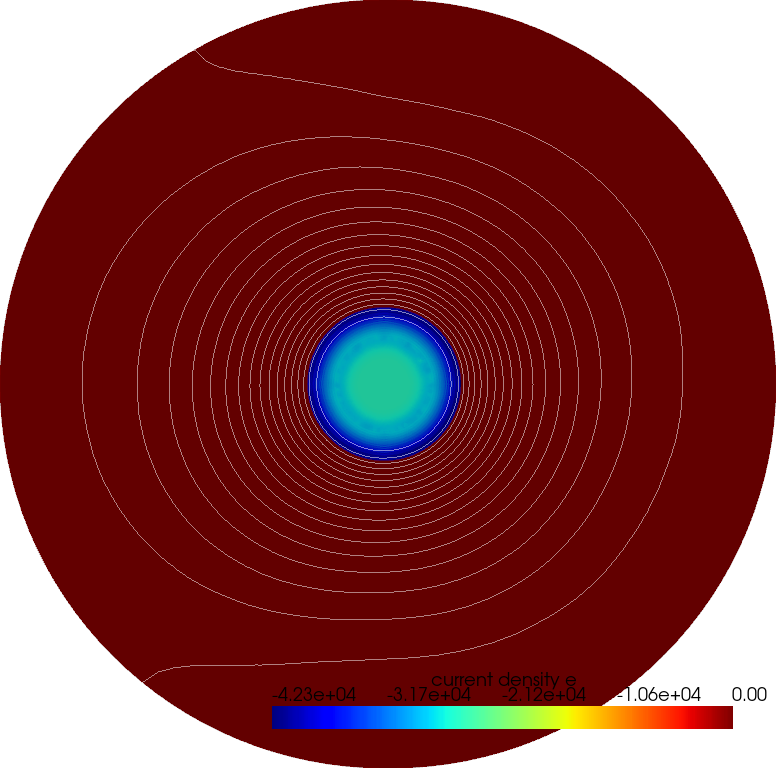

In [9]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_t0, scalars="current density e", component=2, show_edges=False, cmap='jet')
p.add_mesh(mesh_t0.contour(isosurfaces=20, scalars='a', method='contour'),color='white',point_size=1, show_edges=False, opacity=0.5)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()

In [10]:
WIRE_1_ID = 1
WIRE_2_ID = 2

wire_1 = mesh_t0.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")

In [11]:
diameter.to_base_units().m

0.004

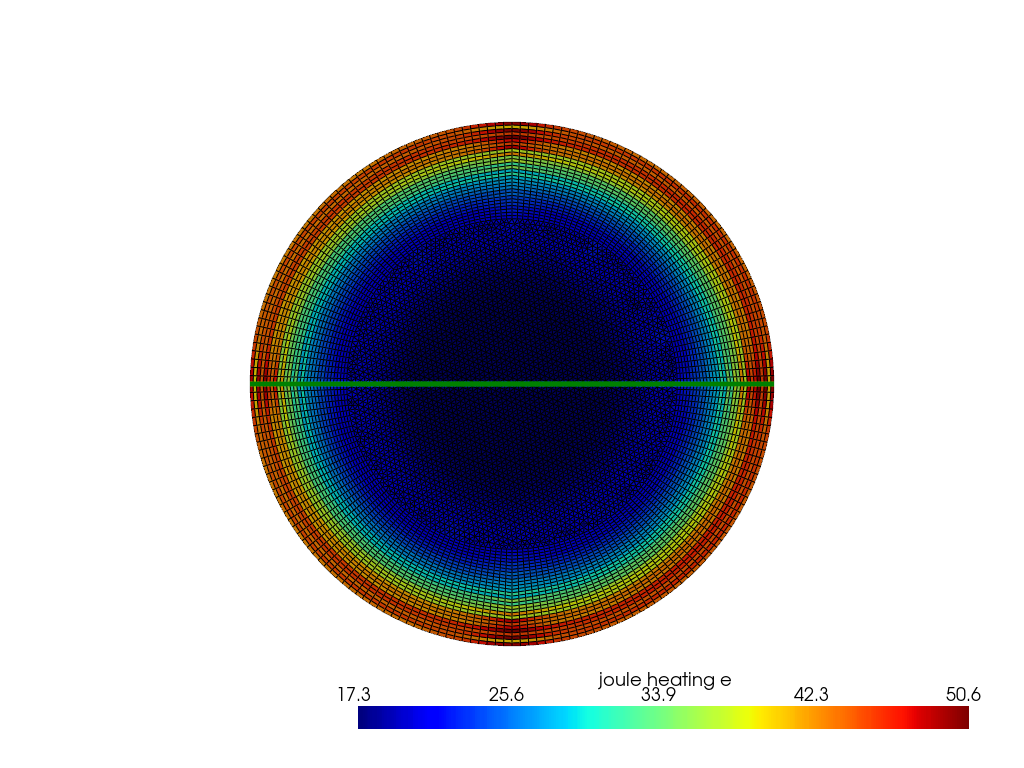

In [12]:
p = pv.Plotter(shape=(1, 1))
p.subplot(0, 0)
p.add_mesh(wire_1, scalars="joule heating e", component=2, show_edges=True, cmap='jet')
#p.update_scalar_bar_range([-200e3, 0])
p.set_viewup([0, 1, 0])
p.add_mesh(pv.Line((-diameter.to_base_units().m/2, 0, 0), (diameter.to_base_units().m/2, 0, 0)), color='green', line_width=5)

# p.subplot(0, 1)

# p.add_mesh(wire_1, scalars="joule heating e", show_edges=True, cmap='jet')
# p.set_viewup([0,1,0])
p.show()

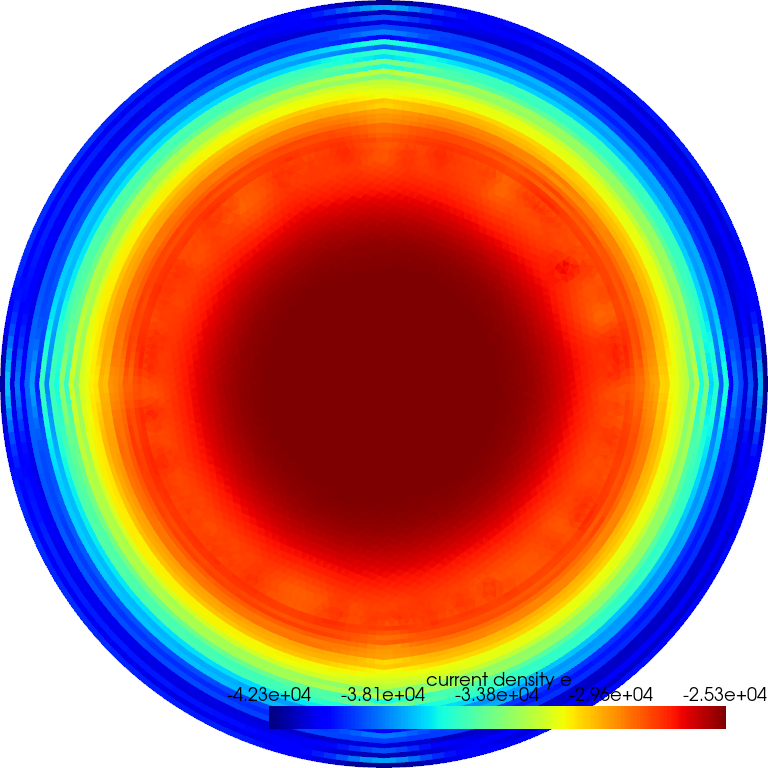

/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4796: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(


In [13]:


p = pv.Plotter(notebook=True, off_screen=True)
p.open_gif('results/j.gif')

mesh = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))
wire_mesh = mesh.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")
p.add_mesh(wire_mesh, scalars="current density e", component=2, show_edges=False, cmap='jet', lighting=False)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()
p.update_scalar_bar_range([-4e5, 4e5])

wire_currrent = np.empty((len(vtu_files), 2)) * Q.A
wire_joule_heating = np.empty((len(vtu_files), 2)) * Q.W / Q.m
wire_current_density = np.empty((len(vtu_files), RESOLUTION+1)) * Q.A / Q.m**2
wire_positions = np.linspace(-diameter/2, diameter/2, RESOLUTION+1)

for idx, vtu_file in enumerate(vtu_files):
    mesh = pv.read(os.path.join(os.curdir,'results', vtu_file))
    for wire in [WIRE_1_ID, WIRE_2_ID]:
        wire_mesh = mesh.threshold([wire - 0.1, wire + 0.1], scalars="GeometryIds")
        wire_mesh_int = wire_mesh.integrate_data()
        wire_currrent[idx, wire - 1] = wire_mesh_int['current density e'][0, 2] * Q.A # 2 is the z component
        wire_joule_heating[idx, wire - 1] = wire_mesh_int['joule heating e'][0] * Q.W / Q.m
        # sample across the wire,
        if wire == WIRE_1_ID:
            p.update_coordinates(wire_mesh.points, render=False)
            p.update_scalars(wire_mesh['current density e'][:,2], render=False)
            p.write_frame()
            line_sample = wire_mesh.sample_over_line((-diameter.to_base_units().m/2,0,0),
                                                     ( diameter.to_base_units().m/2,0,0), resolution=RESOLUTION)
            wire_current_density[idx] = line_sample['current density e'][:,2] * Q.A / Q.m**2
p.close()

In [14]:
delta = np.sqrt((2 * resistivity)/((2*np.pi*frequency).to(Q.rad/Q.s) * mu))
delta.to(Q.mm)

<Quantity(0.370027726, 'millimeter')>

In [15]:
mu / (4e-7 *np.pi)

<Quantity(1.0, 'henry / meter')>

In [16]:
 
def J(r, i, diameter, resistivity, frequency, mu):
    omega = (frequency * 2 * np.pi).to(Q.rad/Q.s)
    delta = np.sqrt((2 * resistivity)/(omega * mu))
    delta.ito(Q.m)
    diameter.ito(Q.m)
    i.ito(Q.A)
    r.ito(Q.m)
    k = (1 - 1j) / delta.m
    j_r = ((k * i.m)/(2 * np.pi * (diameter/2).m)) * (jv(0, (k*r).m) / jv(1, (k*(diameter/2)).m))
    return j_r

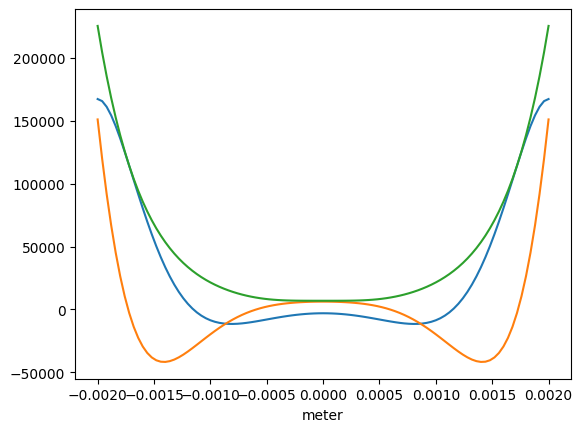

In [17]:
j = J(wire_positions, 1/np.sqrt(2) * Q.A, diameter, resistivity, frequency, mu)

plt.plot(wire_positions, j.real, label='Analytical')
plt.plot(wire_positions, j.imag, label='Analytical')
plt.plot(wire_positions, np.abs(j), label='Analytical')

In [18]:
1/np.sqrt(2) * Q.A / (np.pi * (diameter/2)**2).to(Q.m**2)

<Quantity(56269.7698, 'ampere / meter ** 2')>

In [19]:
r = (1 + 1j) * diameter.to(Q.m) / delta
f_skin = 0.5 * (r.to_base_units().magnitude * iv(0, r.to_base_units().magnitude) / iv(1, r.to_base_units().magnitude)).real

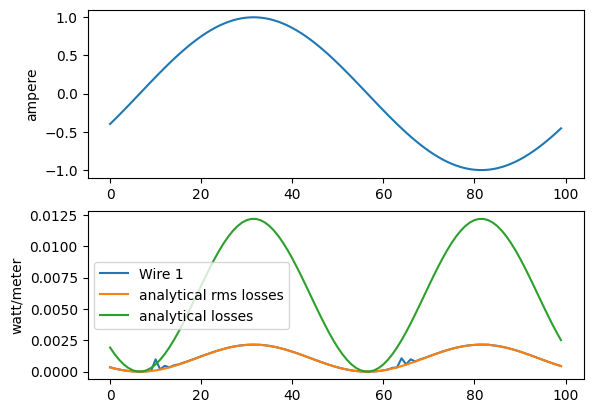

In [20]:

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(wire_currrent[:,0], label='Wire 1')

ax2 = fig.add_subplot(212)
ax2.plot(wire_joule_heating[:,0], label='Wire 1')
ax2.plot(wire_currrent[:,0]**2 * resistance , label='analytical rms losses')
ax2.plot(wire_currrent[:,0]**2 * resistance * f_skin, label='analytical losses')
ax2.legend()

In [21]:
f_skin

np.float64(5.663615734392911)

In [22]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[61791.635139632366 60692.4727908051 59292.958297703524 58370.22334918234 56413.61413280899 55819.60776455613 54996.53798890615 54796.279695973426 54615.106752348074 54932.711187321205 55050.53687556706 55724.857472249445 55947.686934691184 56731.58875328277 56991.43702718355 57689.63749378755 58258.06750777491 58317.90955523004 58305.73209279639 57749.94977644949 57589.89013603978 57243.01283739591 56973.64564133556 56643.27025007135 56415.63036309798 56198.91550696 56054.53681602059 55986.48557128597 55884.12368276249 55826.853583727876 55783.34477905362 55768.73345029139 55766.307065627145 55771.32080206225 55776.72878971988 55790.05560586835 55801.76195245479 55811.286134040434 55827.68286805124 55837.45458178934 55841.43553575029 55846.94175273777 55851.56668510607 55854.22652913568 55855.412177520346 55856.896278934684 55857.28995718253 55857.10461362202 55857.1473287545 55856.94874660945 55856.86681977972 55856.7613958212 55856.939512003104 55857.11154926351 55856.64972725708 55856.51353607823 55855.38973711526 55854.49870740151 55851.8366526688 55849.2376490028 55842.58833549441 55837.26985479412 55831.359087394405 55822.612501718824 55818.26160312517 55810.54524593123 55806.87838877861 55806.34635643904 55819.289764230874 55838.768671440244 55884.031854490044 55917.33891674386 56010.45901031067 56109.548258060415 56189.27915749402 56505.46978921687 56704.83769908822 57017.03215660009 57193.98884247415 57610.640362906786 57859.598282681 58254.17950241191 58714.148415662305 58525.861468812924 58371.55168343333 57829.361232599564 57047.79899727724 56794.77441794187 55990.696923146956 55680.75645772562 55038.85264943603 54866.65897272756 54557.497498296536 54769.194284412166 54929.99499414161 55775.655583600616 56345.549842705776 58320.49058302983 59250.427722022316 60626.530182308685 61686.734032557404]
Units,ampere/meter2


In [28]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[61791.635139632366 60692.4727908051 59292.958297703524 58370.22334918234 56413.61413280899 55819.60776455613 54996.53798890615 54796.279695973426 54615.106752348074 54932.711187321205 55050.53687556706 55724.857472249445 55947.686934691184 56731.58875328277 56991.43702718355 57689.63749378755 58258.06750777491 58317.90955523004 58305.73209279639 57749.94977644949 57589.89013603978 57243.01283739591 56973.64564133556 56643.27025007135 56415.63036309798 56198.91550696 56054.53681602059 55986.48557128597 55884.12368276249 55826.853583727876 55783.34477905362 55768.73345029139 55766.307065627145 55771.32080206225 55776.72878971988 55790.05560586835 55801.76195245479 55811.286134040434 55827.68286805124 55837.45458178934 55841.43553575029 55846.94175273777 55851.56668510607 55854.22652913568 55855.412177520346 55856.896278934684 55857.28995718253 55857.10461362202 55857.1473287545 55856.94874660945 55856.86681977972 55856.7613958212 55856.939512003104 55857.11154926351 55856.64972725708 55856.51353607823 55855.38973711526 55854.49870740151 55851.8366526688 55849.2376490028 55842.58833549441 55837.26985479412 55831.359087394405 55822.612501718824 55818.26160312517 55810.54524593123 55806.87838877861 55806.34635643904 55819.289764230874 55838.768671440244 55884.031854490044 55917.33891674386 56010.45901031067 56109.548258060415 56189.27915749402 56505.46978921687 56704.83769908822 57017.03215660009 57193.98884247415 57610.640362906786 57859.598282681 58254.17950241191 58714.148415662305 58525.861468812924 58371.55168343333 57829.361232599564 57047.79899727724 56794.77441794187 55990.696923146956 55680.75645772562 55038.85264943603 54866.65897272756 54557.497498296536 54769.194284412166 54929.99499414161 55775.655583600616 56345.549842705776 58320.49058302983 59250.427722022316 60626.530182308685 61686.734032557404]
Units,ampere/meter2


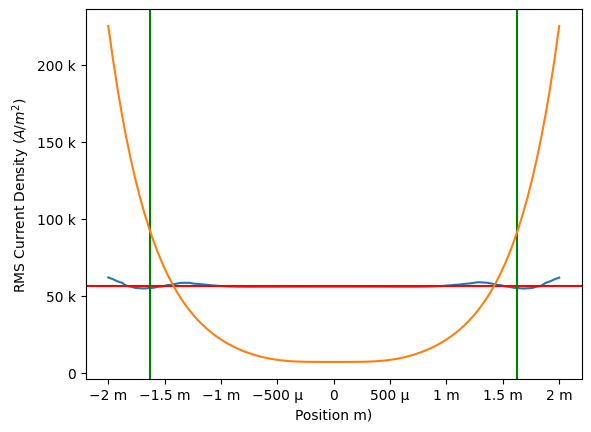

In [24]:

fig = plt.figure()
ax = fig.add_subplot(111)
#use the enginering tick formatter

ax.yaxis.set_major_formatter(EngFormatter())
ax.xaxis.set_major_formatter(EngFormatter())
ax.plot(wire_positions, np.sqrt(np.mean(wire_current_density**2, axis=0)))
ax.set_xlabel('Position m)')
ax.set_ylabel('RMS Current Density ($A/m^2$)')
rms_dc_current_density = np.sqrt(np.mean(wire_currrent**2, axis=0)) / (np.pi * (diameter/2)**2)
ax.axhline(rms_dc_current_density[0], color='red', label='Wire 1 RMS')
ax.axvline(-diameter/2+delta, color='green', label='Skin Depth')
ax.axvline(diameter/2-delta, color='green', label='Skin Depth')
ax.plot(wire_positions, np.abs(j), label='Analytical')

In [25]:
rms_dc_current_density

Magnitude,[56269.64739217168 0.0]
Units,ampere/meter2
